In [ ]:
import json
import torch
from torchvision import models, transforms
from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM

: 

In [ ]:
import pandas as pd
import os
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch.utils.data import Dataset

from sklearn.metrics import precision_recall_fscore_support

: 

In [32]:
path = "/home/justin/Desktop/Resume/Github/Explainable-AI/data"

In [33]:
onlyfiles = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(path) for f in filenames]

In [34]:
df = pd.DataFrame({'file_path': onlyfiles})

In [35]:
def get_label(file_path):
    if "bacteria" in file_path:
        return "1"
    elif "virus" in file_path:
        return "2"
    elif "normal" in file_path:
        return "0"
    else:
        return None
    
def get_data_use(file_path):
    if "train" in file_path:
        return "train"
    elif "test" in file_path:
        return "test"
    elif "val" in file_path:
        return "val"
    else:
        return None

In [36]:
df["label"] = df["file_path"].apply(get_label)
df["usage"] = df["file_path"].apply(get_data_use)
df

,file_path,label,usage
0,/home/justin/Desktop/Resume/Github/Explainable...,2,test
1,/home/justin/Desktop/Resume/Github/Explainable...,2,test
2,/home/justin/Desktop/Resume/Github/Explainable...,2,test
3,/home/justin/Desktop/Resume/Github/Explainable...,2,test
4,/home/justin/Desktop/Resume/Github/Explainable...,2,test
...,...,...,...
5851,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5852,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5853,/home/justin/Desktop/Resume/Github/Explainable...,0,val
5854,/home/justin/Desktop/Resume/Github/Explainable...,0,val


In [37]:
train_df = df[df["usage"]=="train"]
test_df = df[df["usage"]=="test"]
val_df = df[df["usage"]=="val"]

In [38]:
def show_processed_image(filepath:str):
    # open the image and convert it to RGB
    img = Image.open(filepath).convert('RGB')

    # calculate new size while maintaining aspect ratio
    width, height = img.size
    aspect_ratio = 1.4
    new_width = int(height * aspect_ratio)

    # add padding to adjust aspect ratio to 1.4
    padding_width = (new_width - width) // 2
    new_img = Image.new('RGB', (new_width, height), (0, 0, 0))
    new_img.paste(img, (padding_width, 0))

    # resize the image to 224x224
    img = new_img.resize((224, 224))

    return img

In [39]:
df[:866]

,file_path,label,usage
0,/home/justin/Desktop/Resume/Github/Explainable...,2,test
1,/home/justin/Desktop/Resume/Github/Explainable...,2,test
2,/home/justin/Desktop/Resume/Github/Explainable...,2,test
3,/home/justin/Desktop/Resume/Github/Explainable...,2,test
4,/home/justin/Desktop/Resume/Github/Explainable...,2,test
...,...,...,...
861,/home/justin/Desktop/Resume/Github/Explainable...,2,train
862,/home/justin/Desktop/Resume/Github/Explainable...,2,train
863,/home/justin/Desktop/Resume/Github/Explainable...,2,train
864,/home/justin/Desktop/Resume/Github/Explainable...,2,train


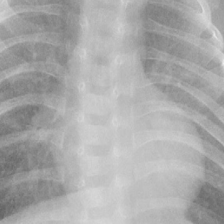

In [40]:
img1 = show_processed_image(df["file_path"][866])
show_processed_image(df["file_path"][866])

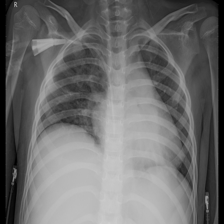

In [41]:
img2 = show_processed_image(df["file_path"][790])
show_processed_image(df["file_path"][790])

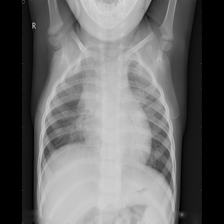

In [42]:
img3 = show_processed_image(df["file_path"][5852])
show_processed_image(df["file_path"][5852])

In [13]:
class ImageClassificationModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('val_loss', loss)
        preds = torch.argmax(y_hat, dim=1)
        acc = torch.sum(preds == y) / float(y.shape[0])
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        # get the true labels and predicted labels
        x, y = batch
        y_hat = model(x)
        preds = torch.argmax(y_hat, dim=1)
        true_labels.append(y.gpu().numpy())
        pred_labels.append(preds.gpu().numpy())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

class CustomDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index]['file_path']
        
        # open the image and convert it to RGB
        img = Image.open(img_path).convert('RGB')

        # calculate new size while maintaining aspect ratio
        width, height = img.size
        aspect_ratio = 1.4
        new_width = int(height * aspect_ratio)

        # add padding to adjust aspect ratio to 1.4
        padding_width = (new_width - width) // 2
        new_img = Image.new('RGB', (new_width, height), (0, 0, 0))
        new_img.paste(img, (padding_width, 0))

        # resize the image to 224x224
        img = new_img.resize((224, 224))
        
        # apply the specified transforms
        img = self.transforms(img)
        
        label = self.data.iloc[index]['label']
        # convert the label to an integer and then to a tensor
        label = torch.tensor(int(label))
        return img, label

# set up transforms for your images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # using ResNet50's recommended normalization
])

# initialize custom datasets
train_dataset = CustomDataset(train_df, transform)
val_dataset = CustomDataset(val_df, transform)
test_dataset = CustomDataset(test_df, transform)

# set up data loaders for your train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# set up a logger for TensorBoard
logger = TensorBoardLogger('tb_logs', name='image_classification')

# initialize the model and trainer
model = ImageClassificationModel(num_classes=3)
trainer = pl.Trainer(max_epochs=10, logger=logger,accelerator="auto", devices="auto", strategy="auto")

c:\Users\Justin\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Justin\anaconda3\envs\xai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# train the model
trainer.fit(model, train_loader, val_loader)


  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 23.5 M
----------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.057    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Justin\anaconda3\envs\xai\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Justin\anaconda3\envs\xai\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [15]:
model.eval()

ImageClassificationModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [ ]:
# concatenate the true labels and predicted labels
true_labels = []
pred_labels = []

In [16]:
# evaluate on test set
trainer.test(model, test_loader)
# concatenate the true labels and predicted labels
true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

c:\Users\Justin\anaconda3\envs\xai\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_f1_class0         0.26504832145657437
     test_f1_class1         0.39620308007404786
     test_f1_class2         0.22799074447572779
        test_loss            1.346941351890564
  test_precision_class0     0.41025641025641024
  test_precision_class1     0.41025641025641024
  test_precision_class2     0.23809523809523808
   test_recall_class0       0.21314102564102563
   test_recall_class1       0.3833689458689459
   test_recall_class2       0.2419871794871795
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.346941351890564,
  'test_precision_class0': 0.41025641025641024,
  'test_precision_class1': 0.41025641025641024,
  'test_precision_class2': 0.23809523809523808,
  'test_recall_class0': 0.21314102564102563,
  'test_recall_class1': 0.3833689458689459,
  'test_recall_class2': 0.2419871794871795,
  'test_f1_class0': 0.26504832145657437,
  'test_f1_class1': 0.39620308007404786,
  'test_f1_class2': 0.22799074447572779}]